# PyTorch Workflow

Let's explore a an example PyTorch end-to-end workflow.

Reources:
* Ground truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb

* Book Version of the notebook - https://www.learnpytorch.io/01_pytorch_workflow/

In [2]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluting a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [3]:
import torch
from torch import nn # nn contains  all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch Version
torch.__version__

'2.8.0+cu126'

## Data (Preparing and Loading)

Data can be almost anything... in Machine Learning.

* Excel Spreadsheet
* Image of any kind
* Video (Youtube has lots of data...)
* Audio like song or podcast
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, lets create some **known** data using the linear regression formula

We'll use a linear regression formula to make a straight line with know **Parameters**

In [4]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim =1 )
y = weight * X +bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a  training and test set with our data.

In [5]:
# create training/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:],y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might be better visualize our data?

This is where the data exploerer's motto comes in!

"Visualize, visualize, visualize!"

In [6]:
def plot_prediction(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
  """
  Plots training data, testdata and compare predictions.
  """

  plt.figure(figsize = (10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c = "b",s = 4, label = "Training Data" )


  # plot test data in green
  plt.scatter(test_data, test_labels, c = "g", s =4, label = "Testing Data" )

  # are there predictions?
  if predictions is not None:
    # plot prediction if they exist
    plt.scatter(test_data, predictions, c = "r", s =4, label = "Predictions" )

  plt.legend(prop = {"size":14})

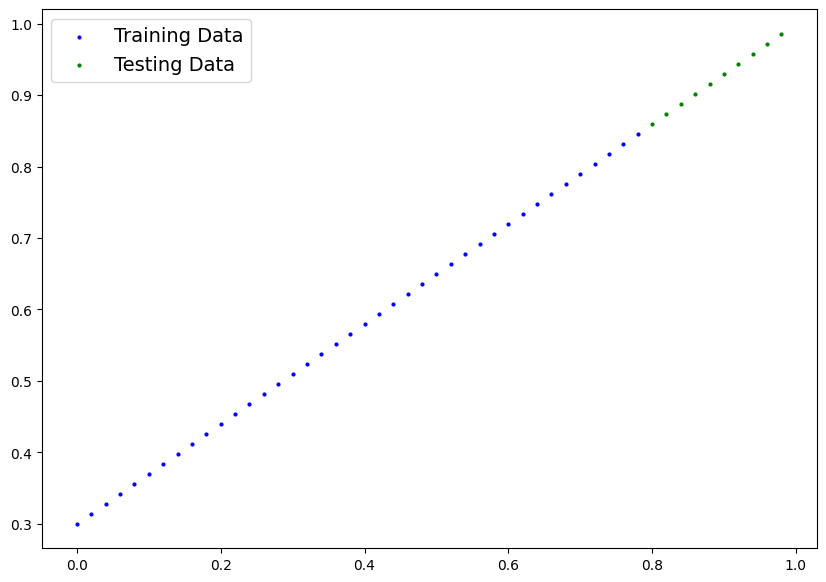

In [7]:
plot_prediction()

## Build model

Our first PyTorch model

https://realpython.com/python3-object-oriented-programming/


What our model does:
* start with random values (weight and bias)
* look at training data and adjust the random values to better represent (or get closer to ) the ideal values (the weight and bias values we used to create the data)


How does it do so?

through two main algorithms:
1. Gradient Descent
2. Backpropagations

In [8]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): #-< almost everthing in PyTorch inherhits from nn.Module
  def __init__(self):
    super().__init__()
    self.weights =  nn.Parameter(torch.randn(1, requires_grad= True, dtype= torch.float))

    self.bias = nn.Parameter(torch.randn(1, requires_grad= True, dtype= torch.float))

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # Linear regression formula



### PyTorch model building essentials

* torch.nn - contain all of the buildings for computional graphs (another word for neural network)
* torch.nn.Parameter - what parameter should our model try and learn, often a PyTorch layer from torch.nn for us
* torch.nn.Module - The base class for all neural networks modules, if you subclass it, you should overwrite foward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
def forward() - All nn.module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

now we've created a model, let's see what's inside...

so we can check our model parameter or what's inside our model using `.parameters()`

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameter
list(model_0.parameters()) # must be be list

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameter
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To Check our model's Predictive power, let's see how weill it predict `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.


In [11]:
# Make prediction with model
with torch.inference_mode():
  y_preds = model_0(X_test)

In [12]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

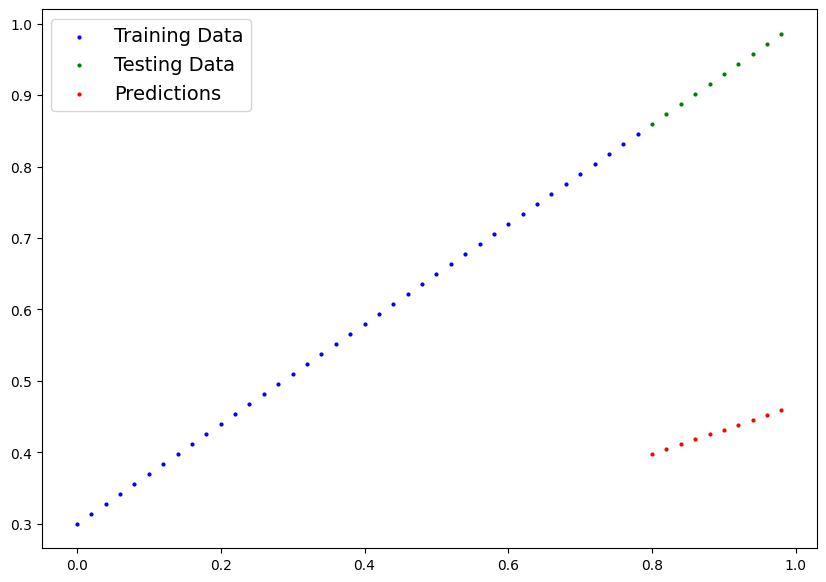

In [13]:
plot_prediction(predictions=y_preds)

## Train Model

The Whole idea of training is for a model from some **unknown** parameters (these my be random) to some *known* parameters.

or in other words from a poor representation of the data to a better represantation of the data

One way to measure how poor or how wrong your models predictions are is to use a loss function.


* Note: loss function may also be called cost function or cireterion in different areas. For our case, we're going to refer to it as a loss function.

Things we need to train:

* **Loss Function**: a Function to measure how wrong your model's predictions are to the ideal outputs, lower is better

* **Optimizer** : take into account the loss of a model and adjusts the model's parameter (e.g weight and bias) to improgve the loss function.


And specifically for PyTorch, we need:
* A Training Loop
* A Testing Loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
# Check out our model's params
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# setup a loss function
loss_fn = nn.L1Loss()


# setup an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01) #lr = learning  rate = possibly the most important hyperparameter you can set


### Building a training loop (and a testing loop )in PyTorch

A Couple of thing we need in a training loop

0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()`functions) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer Zero Grad
4. Loss Backward - Move backward through the network to calculate the gradients of each of paramter of our model with respect to the loss (**Backpropagation**)
5. Optimizer Step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient Descent**)




In [17]:
%time 

torch.manual_seed(42)

# An Epoch is one loop of the data... (this is a hyperparameter because we've set ourselves)
epochs = 200


# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    # set the model to training mode
    
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to  require gradients
    
    # 1.Forward Pass
    y_pred = model_0(X_train)
    
    # 2.Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer Zero Grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagtion on the loss with respect to the parameters of the model
    loss.backward()
    
    # Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will acculumate through the loop so ... we have to zero them above in step 3 for the next iteration of the loop
    
    model_0.eval() #turns off gradient tracking 
    
    # testing
    with torch.inference_mode(): # turn off gradient tracking & a couple more things behind the scenes 
        # 1. do the forward pass 
        test_pred = model_0(X_test)
        
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    # print out what happening
    if epoch % 10 == 0: 
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        
        
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")
        
        # print out model state_dict()
        print(model_0.state_dict()) 
    

CPU times: total: 0 ns
Wall time: 3.81 μs
Epoch: 0 | Loss: 0.31288138031959534 | Test Loss: 0.48106518387794495
OrderedDict({'weights': tensor([0.3406]), 'bias': tensor([0.1388])})
Epoch: 10 | Loss: 0.1976713240146637 | Test Loss: 0.3463551998138428
OrderedDict({'weights': tensor([0.3796]), 'bias': tensor([0.2388])})
Epoch: 20 | Loss: 0.08908725529909134 | Test Loss: 0.21729660034179688
OrderedDict({'weights': tensor([0.4184]), 'bias': tensor([0.3333])})
Epoch: 30 | Loss: 0.053148526698350906 | Test Loss: 0.14464017748832703
OrderedDict({'weights': tensor([0.4512]), 'bias': tensor([0.3768])})
Epoch: 40 | Loss: 0.04543796554207802 | Test Loss: 0.11360953003168106
OrderedDict({'weights': tensor([0.4748]), 'bias': tensor([0.3868])})
Epoch: 50 | Loss: 0.04167863354086876 | Test Loss: 0.09919948130846024
OrderedDict({'weights': tensor([0.4938]), 'bias': tensor([0.3843])})
Epoch: 60 | Loss: 0.03818932920694351 | Test Loss: 0.08886633068323135
OrderedDict({'weights': tensor([0.5116]), 'bias':

In [18]:
import numpy as np
np.array(torch.tensor(loss_values).cpu().numpy())

C:\Users\patri\AppData\Local\Temp\ipykernel_1656\3856275706.py:2: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  np.array(torch.tensor(loss_values).cpu().numpy())


array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

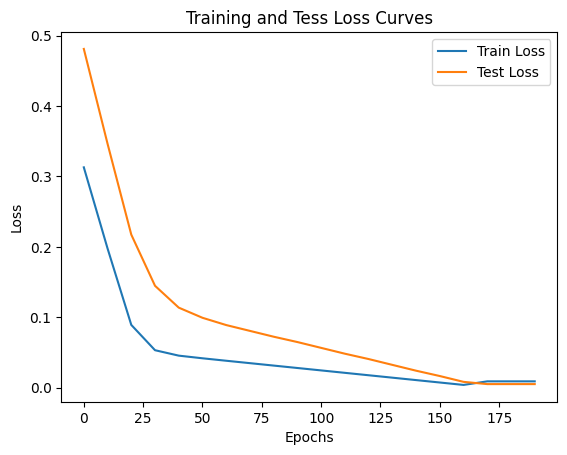

In [19]:
# Plot the loss curves

plt.plot(epoch_count,np.array(torch.tensor(loss_values).numpy()),  label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test Loss")
plt.title("Training and Tess Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [20]:
epoch_count

[0,
 10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190]

In [21]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

In [22]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [23]:
weight, bias

(0.7, 0.3)

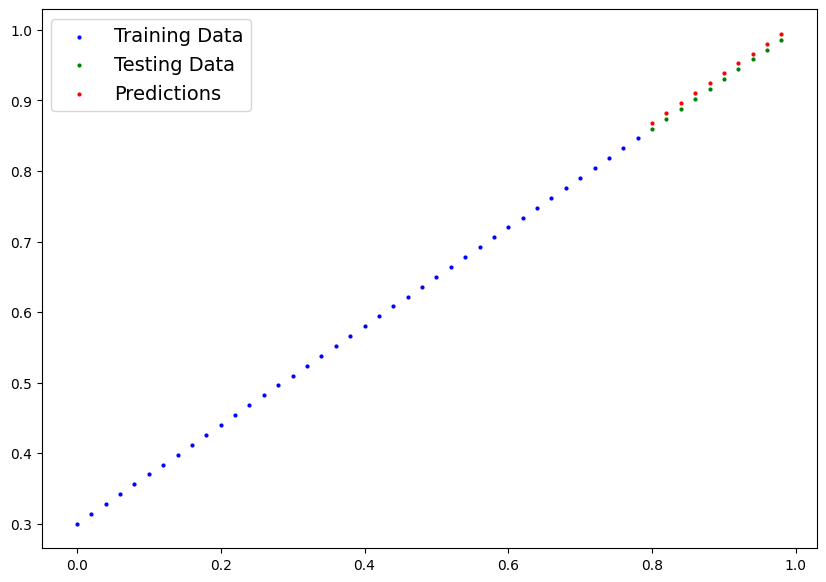

In [24]:
plot_prediction(predictions = y_preds_new)

## Saving a model in PyTorch

there are three main methods you should know about for saving and loading models in PyTorch

1. `torch.save` - allow you save a PyTorch object in Pytho pickle format
2. `torch.load` - allow you load a saved PyToch object
3. `torch.nn.Module.load_state_dict()` - this allow to load a model's saved state dict

In [25]:
# saving our PyTorch model
from pathlib import Path 

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model sve path
MODEL_NAME = "01_Pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME



print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),f =MODEL_SAVE_PATH)

Saving model to: models\01_Pytorch_workflow_model_0.pth


## loading a PyTorch Model

Since we saved our model `state_dict` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that. 

In [26]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [27]:
# To Load in a saved state_dict we have to instatiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# load the save state_dict of model_0 (this will update the new instance with updated parameters)
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [28]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [29]:
# Make some prediction with our loaded model

loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
    
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [30]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

In [31]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Lets's go back through the steps above and see it all in one place

In [32]:
# Import PyTorch and Matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt 


# check pytorch version
torch.__version__

'2.8.0+cu126'

Create device-agnostic code.

this means if we've got access to a GPU, our code will use it (for potentially faster computing)

if no GPU is available  the code will default to using CPU 

In [33]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cuda


### 6.1 Data

In [34]:
# Create some data using the linear regression formula of y =  weight * X + bias 

weight = 0.7
bias = 0.3

# create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X  = torch.arange(start, end, step).unsqueeze(dim = 1) #without unsqueeze, error  will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [35]:
# split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

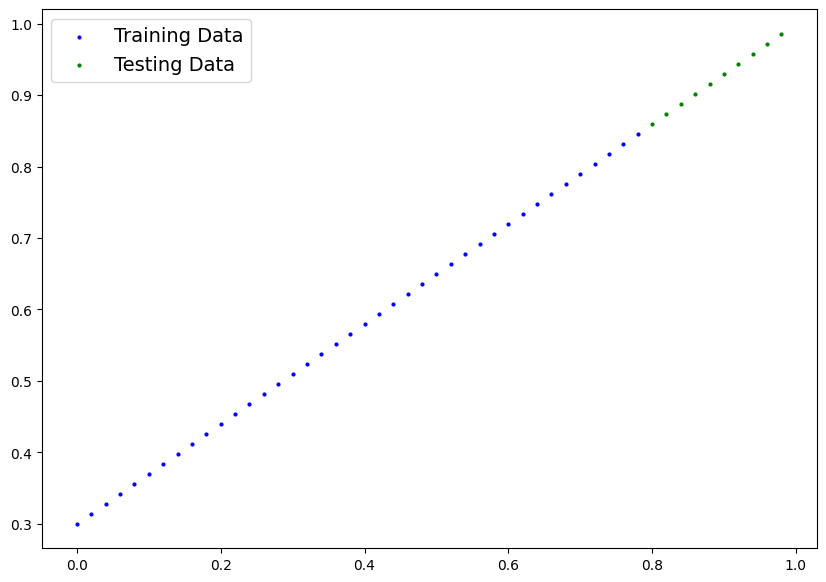

In [36]:
# Plot the data
# Note if you dont have the plot_prediction() function loaded, this will error

plot_prediction(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear Model

In [37]:
# create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating model parameter / also called: Linear Transfrom, probing layer,
        self.linear_layer = nn.Linear(in_features = 1,
                                      out_features =1 )
    
    def forward(self,x : torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1,model_1.state_dict()
        

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [38]:
# Check the model current device 
next(model_1.parameters()).device

device(type='cpu')

In [39]:
# Set the model to use the target device 
model_1 = model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training 

For training we need:
* Loss Function
* Optimizer
* Training Loop
* Testing Loop



In [40]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE 

# setup our optimizer 
optimizer = torch.optim.SGD(params = model_1.parameters(),lr = 0.01 )

In [41]:
# Lets write a training loop 
torch.manual_seed(42)

epochs = 200 

# put data on the target device (device agonistic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    # 1. Forward pass
    y_pred = model_1(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Perform backpropagation
    loss.backward()
    
    # 5. Optimizer Step
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        
        test_loss = loss_fn(test_pred, y_test)
        
    #  print whats happening
    if epoch % 10 == 0 :
        print(f"Epoch: {epoch} | Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}") 
        

Epoch: 0 | Train Loss: 0.5552 | Test Loss: 0.5740
Epoch: 10 | Train Loss: 0.4400 | Test Loss: 0.4393
Epoch: 20 | Train Loss: 0.3248 | Test Loss: 0.3046
Epoch: 30 | Train Loss: 0.2095 | Test Loss: 0.1698
Epoch: 40 | Train Loss: 0.0943 | Test Loss: 0.0351
Epoch: 50 | Train Loss: 0.0239 | Test Loss: 0.0478
Epoch: 60 | Train Loss: 0.0200 | Test Loss: 0.0458
Epoch: 70 | Train Loss: 0.0165 | Test Loss: 0.0375
Epoch: 80 | Train Loss: 0.0131 | Test Loss: 0.0299
Epoch: 90 | Train Loss: 0.0097 | Test Loss: 0.0217
Epoch: 100 | Train Loss: 0.0062 | Test Loss: 0.0141
Epoch: 110 | Train Loss: 0.0028 | Test Loss: 0.0058
Epoch: 120 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 130 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 140 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 150 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 160 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 170 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 180 | Train Loss: 0.0013 | Test Loss: 0.0138
Epoch: 190 | Train Loss

In [42]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Marking and evaluating predictions

In [43]:
# Turn model into evaluation mode

model_1.eval()

# make prediction on the test data 
with torch.inference_mode():
    y_preds = model_1(X_test)
    
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

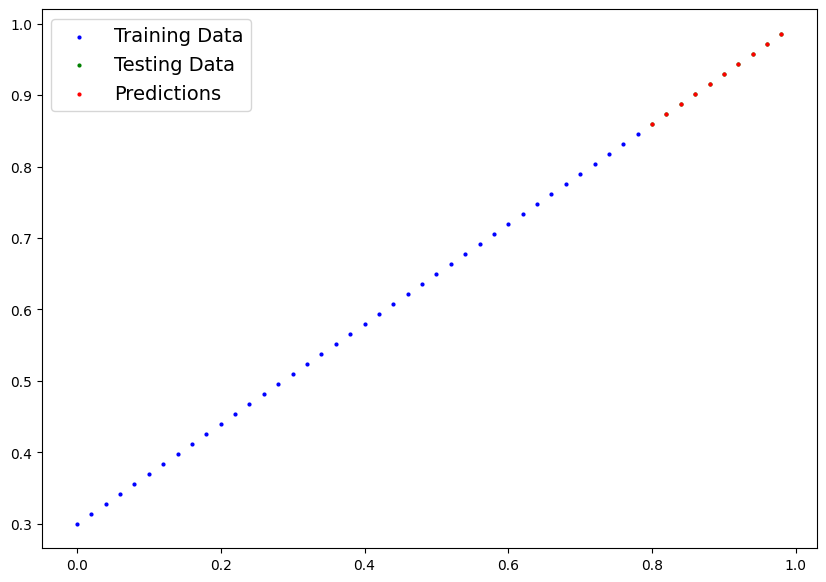

In [45]:
# check out our model predictions visually 

plot_prediction(predictions= y_preds.cpu())

### 6.5 Saving and Loading a trained model 

In [50]:
from pathlib import Path 

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents= True, exist_ok= True)


# 2. Create model save path 
MODEL_NAME = "01_PyTorch_Workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving Model to {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving Model to models\01_PyTorch_Workflow_model_1.pth


In [53]:
# Load a PyTorch


# Create a new instance of linear regression model V2 
loaded_model_1 = LinearRegressionModelV2()

# load the saved model_1 stated_dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [54]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [55]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [56]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds    

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')